In [ ]:
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd Hierarchical-Localization
!pip install -e . --quiet
!pip install --progress-bar off --quiet --upgrade plotly

/content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 42.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
from hloc import extract_features, match_features, match_dense, reconstruction, visualization, pairs_from_exhaustive, pairs_from_retrieval
from hloc.utils import viz_3d
from hloc.visualization import plot_images, read_image

import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm
from pathlib import Path

%cd /content

/content


In [ ]:
images = Path('/content/data')
outputs = Path('outputs/model/')
!rm -rf $outputs
sfm_pair = outputs / 'sfm_pair.txt'
loc_pair = outputs / 'loc_pair.txt'
sfm_model = outputs / 'sfm'
feature = outputs / 'feature.h5'
match = outputs / 'match.h5'

20 images total, here are 8 samples:


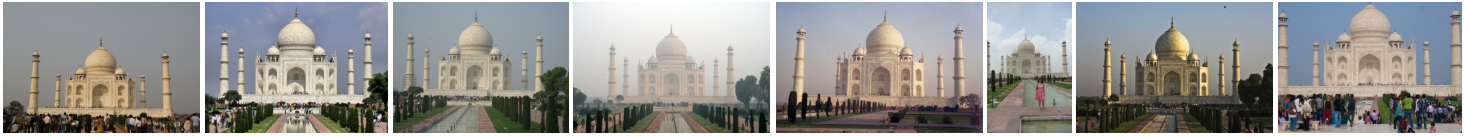

In [ ]:
data = [str(image.relative_to(images)) for image in (images).iterdir()]
print(len(data), "images total, here are 8 samples:")
plot_images([read_image(images / i) for i in data if "checkpoint" not in i][:8], dpi=30)

In [ ]:
def retrieval(retrieval_method, num_match = 5):
  if retrieval_method == 'bf':
    pairs_from_exhaustive.main(sfm_pair, image_list=data)
  else:
    retrieval_conf = extract_features.confs[retrieval_method]
    descriptor = extract_features.main(retrieval_conf, images, outputs)
    pairs_from_retrieval.main(descriptor, sfm_pair, num_matched=num_match)

def dense_method(retrieval_method,feature_method,match_method):
  feature_conf = extract_features.confs[feature_method]
  dense_conf = match_dense.confs[match_method]
  retrieval(retrieval_method)
  extract_features.main(feature_conf, images, outputs, image_list=data, feature_path=feature)
  features, matches = match_dense.main(dense_conf, sfm_pair, images, features = feature_conf['output'], export_dir=outputs)

  return features, matches

def sparse_method(retrieval_method,feature_method,match_method):
  feature_conf = extract_features.confs[feature_method]
  sparse_conf = match_features.confs[match_method]
  retrieval(retrieval_method, num_match = 5)
  features = extract_features.main(feature_conf, images, outputs)
  matches = match_features.main(sparse_conf, sfm_pair, feature_conf['output'], outputs)

  return features, matches


In [ ]:
import warnings
warnings.filterwarnings("ignore")
features, matches = sparse_method('netvlad','disk','disk+lightglue')

[2023/12/10 18:17:16 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2023/12/10 18:17:16 hloc INFO] Found 20 images in root /content/data.
100%|██████████| 529M/529M [00:23<00:00, 23.2MB/s]
100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
[2023/12/10 18:18:01 hloc INFO] Finished exporting features.
[2023/12/10 18:18:01 hloc INFO] Extracting image pairs from a retrieval database.
[2023/12/10 18:18:01 hloc INFO] Found 100 pairs.
[2023/12/10 18:18:01 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
[2023/12/10 18:18:01 hloc INFO] Found 20 images in root /content/data.
Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth
100%|██████████| 4.17M/4.17M 

In [ ]:
model = reconstruction.main(sfm_model, images, sfm_pair, features, matches, image_list=data)

[2023/12/10 18:18:14 hloc INFO] Creating an empty database...
[2023/12/10 18:18:14 hloc INFO] Importing images into the database...
[2023/12/10 18:18:15 hloc INFO] Importing features into the database...
100%|██████████| 20/20 [00:00<00:00, 956.01it/s]
[2023/12/10 18:18:15 hloc INFO] Importing matches into the database...
100%|██████████| 100/100 [00:00<00:00, 1406.10it/s]
[2023/12/10 18:18:15 hloc INFO] Performing geometric verification of the matches...
[2023/12/10 18:18:16 hloc INFO] Running 3D reconstruction...
[2023/12/10 18:19:57 hloc INFO] Reconstructed 1 model(s).
[2023/12/10 18:19:57 hloc INFO] Largest model is #0 with 20 images.
[2023/12/10 18:19:57 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 20
	num_cameras = 20
	num_points3D = 5230
	num_observations = 65448
	mean_track_length = 12.514
	mean_observations_per_image = 3272.4
	mean_reprojection_error = 0.997751
	num_input_images = 20


In [ ]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

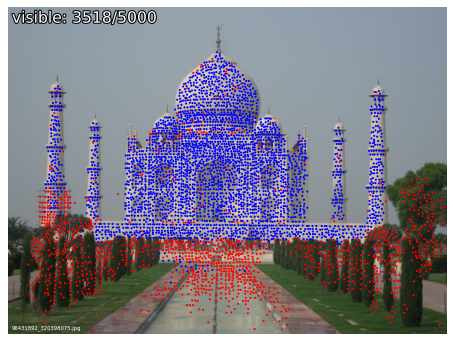

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=1, seed = 4)

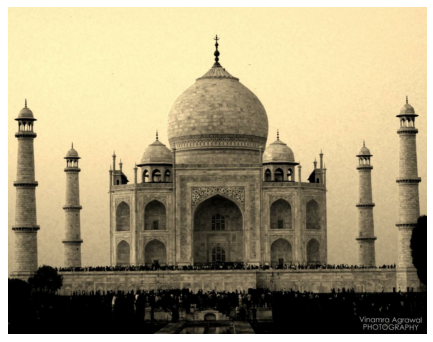

In [ ]:
query = 'query/94491171_8777596299.jpg'
plot_images([read_image(images / query)], dpi=75)

In [ ]:
references = [model.images[i].name for i in model.reg_image_ids()]
feature_conf = extract_features.confs["disk"]
sparse_conf = match_features.confs['disk+lightglue']
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pair, image_list=[query], ref_list=references)
match_features.main(sparse_conf, loc_pair, features=features, matches=matches, overwrite=True)

[2023/12/10 18:22:46 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]
[2023/12/10 18:22:46 hloc INFO] Finished exporting features.
[2023/12/10 18:22:46 hloc INFO] Found 20 pairs.
[2023/12/10 18:22:46 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
100%|██████████| 20/20 [00:01<00:00, 12.22it/s]
[2023/12/10 18:22:48 hloc INFO] Finished exporting matches.


PosixPath('outputs/model/feats-disk_matches-disk-lightglue_sfm_pair.h5')

found 4044/5696 inlier correspondences.


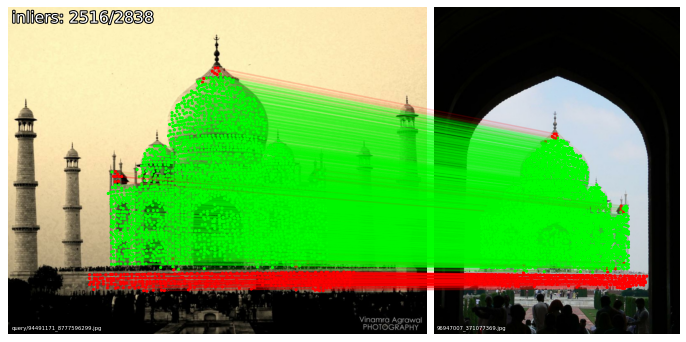

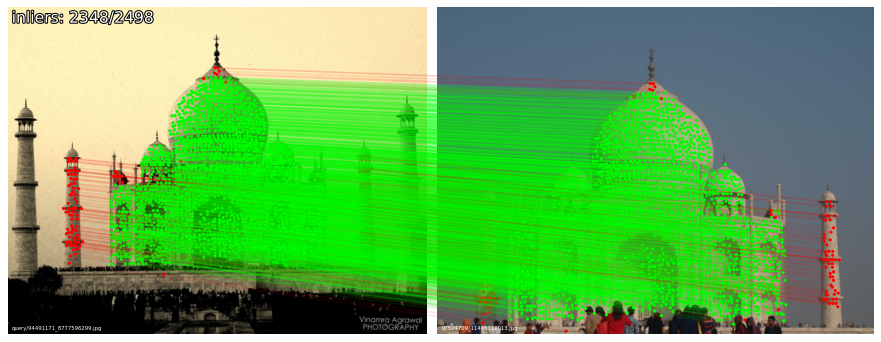

In [ ]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster
import numpy as np

camera = pycolmap.infer_camera_from_image(images / query)
reference_ids = [model.find_image_with_name(n).image_id for n in references]
config = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localize = QueryLocalizer(model, config)
result, log = pose_from_cluster(localize, query, camera, reference_ids, features, matches)

print(f'found {result["num_inliers"]}/{len(result["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

In [ ]:
poses = pycolmap.Image(tvec=result['tvec'], qvec=result['qvec'])
viz_3d.plot_camera_colmap(fig, poses, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
inline_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[result['inliers']]])
viz_3d.plot_points(fig, inline_3d, color="lime", ps=1, name=query)
fig.show()